## Predicting Airline Delays<br>

Notebook: Data Modeling
  
Team: Jimmy Nguyen, Maha Jayapal, Roberto Cancel<br>

## Packages 

In [1]:
#!pip install --upgrade numpy #ensure numpy and pandas are upgraded to same versions for easier exploration (avoiding errors)
#!pip install --upgrade pandas #ensure numpy and pandas are upgraded to same versions for easier exploration (avoiding errors)
!pip install xgboost

import tarfile
import pickle as pkl
import boto3
import sagemaker
from sagemaker import image_uris
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
import io # for encoding issues with raw data sets
from io import StringIO # converting dataframe to csv and uploading to s3 bucket /tranformed folder

import pandas as pd
import numpy as np
import xgboost
from xgboost import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
import pickle as pkl
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


## Set-up 

In [2]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [3]:
print("Default bucket: {}".format(bucket))

Default bucket: sagemaker-us-east-1-957093009964


## Train, Validation, and Test Data 

In [4]:
s3_client = boto3.resource('s3')

# training data
BUCKET = 'ads-508-airline'
KEY = "model_data/df_train.csv"

response = s3_client.Object(BUCKET, KEY)
train = pd.read_csv(response.get()['Body'])
train.head()

,DEP_DEL15,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE,PRCP,SNOW,SNWD,TMAX,AWND,WEEK_OF_MONTH
0,1.0,3,3,4,2840,4905,3888,726,0.00,0.0,0.0,50.0,1.57,4
1,1.0,3,3,4,2444,23,2273,787,0.29,0.9,1.2,41.0,12.30,2
2,1.0,4,4,7,7637,16888,15237,4991,0.00,0.0,1.2,27.0,14.99,3
3,1.0,7,4,5,5175,1407,4076,2145,0.04,0.0,0.0,67.0,16.11,1
4,0.0,5,2,4,7637,16888,15237,4991,0.00,0.0,0.0,57.0,2.01,4


In [5]:
# validation data
KEY = "model_data/df_val.csv"

response = s3_client.Object(BUCKET, KEY)
valid = pd.read_csv(response.get()['Body'])
valid.head()

,DEP_DEL15,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE,PRCP,SNOW,SNWD,TMAX,AWND,WEEK_OF_MONTH
0,0.0,1,2,4,8989,9668,15475,2482,0.0,0.0,0.0,42.0,8.05,1
1,1.0,4,3,4,8989,9668,15475,2482,0.0,0.0,0.0,60.0,5.82,3
2,0.0,5,4,3,8989,9668,15475,2482,0.0,0.0,0.0,61.0,2.68,1
3,1.0,2,3,8,8989,9668,15475,2482,0.0,0.0,0.0,55.0,2.91,4
4,0.0,7,2,2,8989,9668,15475,2482,0.0,0.0,0.0,52.0,9.84,4


In [6]:
# Test data
KEY = "model_data/df_test.csv"

response = s3_client.Object(BUCKET, KEY)
test = pd.read_csv(response.get()['Body'])
test.head()

,DEP_DEL15,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,PILOTS_COPILOTS,PASSENGER_HANDLING,PASS_GEN_SVC_ADMIN,MAINTENANCE,PRCP,SNOW,SNWD,TMAX,AWND,WEEK_OF_MONTH
0,1.0,1,2,5,8989,9668,15475,2482,0.0,0.0,0.0,53.0,3.36,5
1,0.0,4,3,6,7637,16888,15237,4991,0.0,0.0,0.0,68.0,4.70,4
2,1.0,4,4,4,8989,9668,15475,2482,0.0,0.0,0.0,80.0,9.40,4
3,1.0,6,3,3,8989,9668,15475,2482,0.0,0.0,0.0,41.0,7.61,1
4,0.0,2,2,5,8586,8586,15502,9677,0.0,0.0,0.0,50.0,9.17,3


## S3 Data Inputs for Modeling 

In [7]:
# Training data
KEY = "model_data/df_train.csv"
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}'.format(BUCKET, KEY), content_type='csv')
s3_input_train

In [8]:
# Validation data
KEY = "model_data/df_val.csv"
s3_input_valid = sagemaker.TrainingInput(s3_data='s3://{}/{}'.format(BUCKET,KEY), content_type='csv')

In [9]:
# Test data
KEY = "model_data/df_test.csv"
s3_input_test = sagemaker.TrainingInput(s3_data='s3://{}/{}'.format(BUCKET, KEY), content_type='csv')

## Modeling - XGBOOST

In [10]:
# initialize hyperparameters
hyperparameters = {
        "max_depth":"5", #default 6 - reduced to reduce complexity and overfitting
        "eta":"0.3", #default
        "gamma":"0", #default
        "min_child_weight":"1", #default
        "subsample":"0.5", #optimized to prevent overfitting
        "lambda":"1", #default
        "objective":"binary:logistic",
        "num_round":"50", "eval_metric":"auc"}

# set an output path where the trained model will be saved
bucket = sagemaker.Session().default_bucket()
prefix = 'baseline_model'
output_path = 's3://{}/{}/{}/output'.format(bucket, prefix, 'xgb-built-in-algo')

# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
# specify the repo_version depending on your preference.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", region, "1.2-2")

# construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          instance_count=1, 
                                          instance_type='ml.m5.large', 
                                          volume_size=5, # 5 GB 
                                          output_path=output_path)

# define the data type and paths to the training and validation datasets
content_type = "libsvm"

# execute the XGBoost training job
estimator.fit({'train': s3_input_train, 'validation': s3_input_valid})

2022-04-01 17:29:58 Starting - Starting the training job...ProfilerReport-1648834197: InProgress
......
2022-04-01 17:31:18 Starting - Preparing the instances for training.........
2022-04-01 17:32:58 Downloading - Downloading input data...
2022-04-01 17:33:18 Training - Downloading the training image.........
2022-04-01 17:34:59 Training - Training image download completed. Training in progress.[2022-04-01 17:34:52.616 ip-10-0-126-225.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-04-01:17:34:52:INFO] Imported framework sagemaker_xgboost_container.training
[2022-04-01:17:34:52:INFO] Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
[2022-04-01:17:34:52:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2022-04-01:17:34:52:INFO] No GPUs detected (normal if no gpus installed)
[2022-04-01:17:34:52:INFO] Running XGBoost Sagemaker in algorithm mode
[2022-04-01:17:34:52:

## Evaluation 

In [11]:

# download the model artifact from AWS S3
!aws s3 cp s3://sagemaker-us-east-1-957093009964/baseline_model/xgb-built-in-algo/output/sagemaker-xgboost-2022-03-31-00-49-48-555/output/model.tar.gz .
    
#opens the downloaded model artifcat and loads it as 'model' variable
tar = tarfile.open('model.tar.gz')
tar.extractall()
tar.close()
model = pkl.load(open('xgboost-model', 'rb'))

download: s3://sagemaker-us-east-1-957093009964/baseline_model/xgb-built-in-algo/output/sagemaker-xgboost-2022-03-31-00-49-48-555/output/model.tar.gz to ./model.tar.gz


### Feature Importance:

Feature importance is evaluated using weight (the number of times a feature is used to split the data across all trees), cover (the number of times a feature is used to split the data cross all trees weighted by the number of training data points that go through those splits), and gain (the average training loss reduction when using a feature for splitting).

In [12]:
cols_input = ['DAY_OF_WEEK', 'DEP_TIME_BLK', 'DISTANCE_GROUP',
       'PILOTS_COPILOTS', 'PASSENGER_HANDLING', 'PASS_GEN_SVC_ADMIN',
       'MAINTENANCE', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND', 'WEEK_OF_MONTH']
cols_target = ['DEP_DEL15']

# Match up with feature names 
map_names = dict(zip(list(model.get_fscore().keys()), train[cols_input].columns))
model.feature_names = list(map_names.values())

map_names2 = dict(zip(list(model.get_fscore().keys()), train[cols_target].columns))
model.target_names = list(map_names2.values())


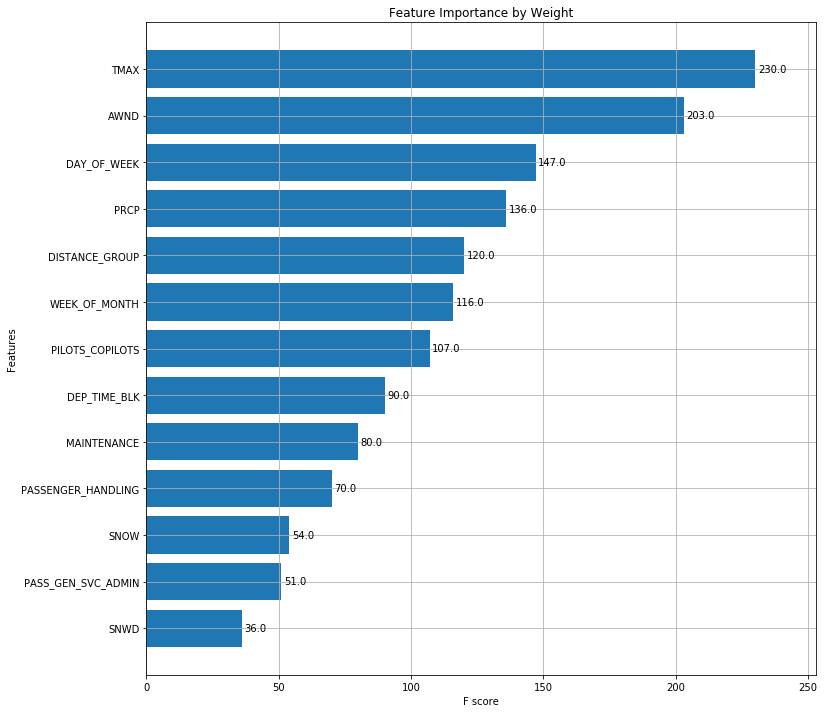

In [13]:
#plot feature importance with weight
fig, ax = plt.subplots(figsize=(12,12))
xgboost.plot_importance(model, importance_type='weight', max_num_features=30, height=0.8, ax=ax, show_values = True)
plt.title('Feature Importance by Weight')
plt.show()

Feature importance by weight ranks features based on the number of times a feature is used to split the data across all trees, we see that the 8 most frequently used features across all trees are: TMAX, AWND, DAY_OF_WEEK, PRCP, DISTANCE_GROUP, WEEK_OF_MONTH, PILOTS_COPILOTS, and DEPT_TIME_BLK. <br>

Summary: Weather conditions, date/time-oriented features, flight length, and staffing levels (pilots/copilots) are the most influential features across all trees at a high-level. <br>

Preliminary Interpretations: While weather conditions aren't features that can be changed by the airline, understanding the interactions of these features with the remaining features would be beneficial. DAY_OF_WEEK, WEEK_OF_MONTH, and DEP_TIME_BLK indicate airport activity and staffing levels are important factors in predicting departure delays.<br>

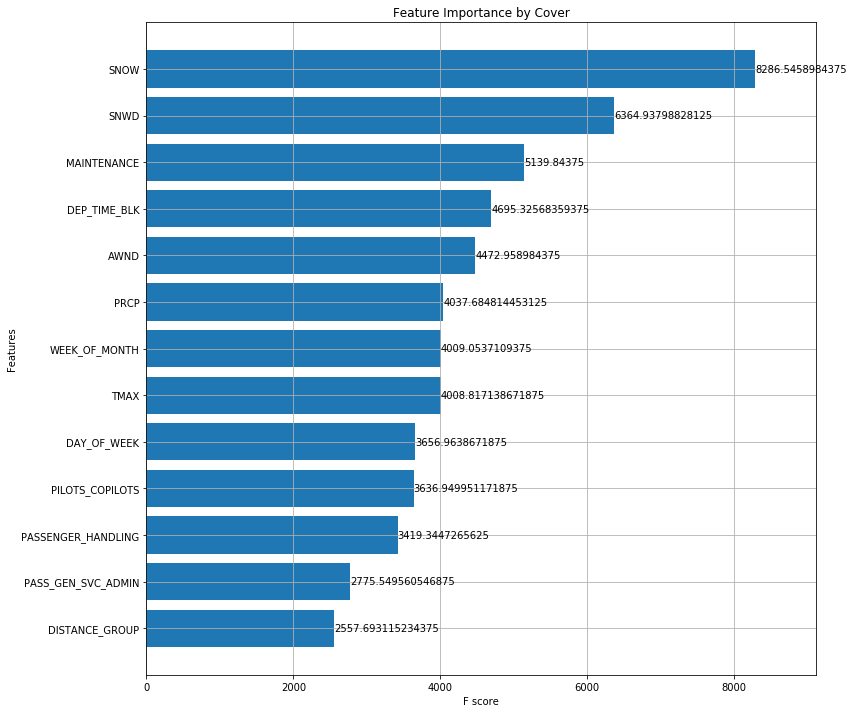

In [14]:
#plot feature importance with cover
fig, ax = plt.subplots(figsize=(12,12))
xgboost.plot_importance(model, importance_type='cover', max_num_features=30, height=0.8, ax=ax, show_values = True)
plt.title('Feature Importance by Cover')
plt.show()

Feature importance by cover ranks features based on the number of times a feature is used to split the data cross all trees weighted by the number of training data points that go through those splits,  we see that the 8 most frequently used features are: SNOW, SNWD, MAINTENANCE, DEPT_TIME_BLK, AWND, PRCP, WEEK_OF_MONTH, and TMAX.<br>
  
Summary: Once again, weather conditions, date/time-oriented features, and staffing levels (maintenance) are the most influential features for splitting trees with respect to the number of training points passed through those splits.<br>

Preliminary Interpretations: We see a similar pattern of features when evaluating by cover. <br>

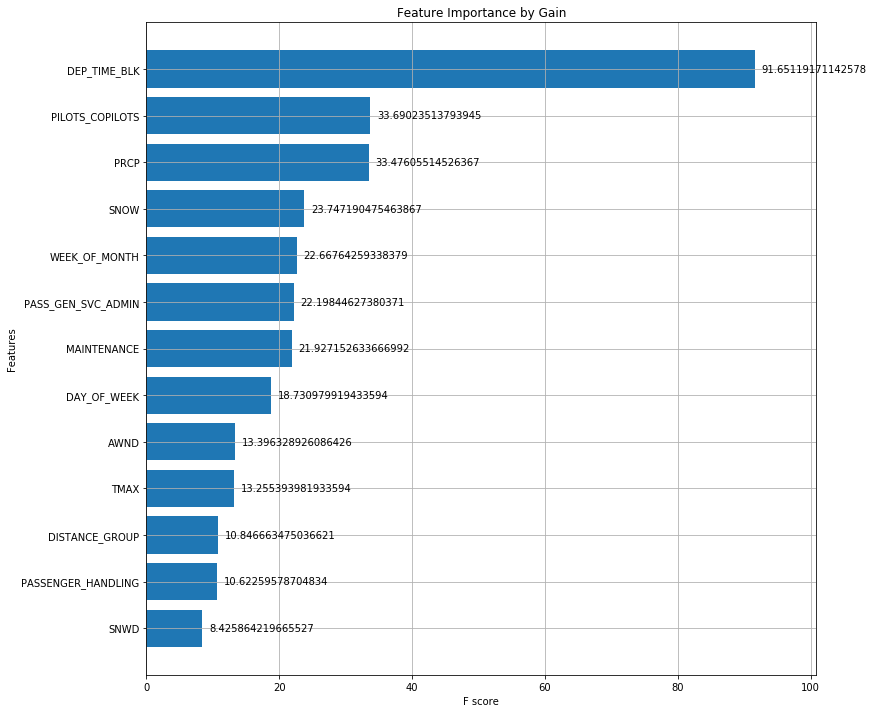

In [15]:
#plot feature importance with gain
fig, ax = plt.subplots(figsize=(12,12))
xgboost.plot_importance(model, importance_type='gain', max_num_features=30, height=0.8, ax=ax, show_values = True)
plt.title('Feature Importance by Gain')
plt.show()

Feature importance by gain ranks features based on the average training loss reduction when using a feature for splitting, we see that the 8 most frequently used features are: DEP_TIME_BLK, PILOTS_COPILOTS, PRCP, SNOW, WEEK_OF_MONTH, PASS_GEN_SVC_ADMIN, MAINTENANCE, and DAY_OF_WEEK.<br>

Summary: Once again, weather conditions, date/time-oriented features, and staffing levels (maintenance) are the most influential features for splitting trees with respect to the number of training points passed through those splits.<br>


## Future Enhancements